In [1]:
import sys
import os
from os.path import join
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

PROJ_ROOT = os.pardir
checkpoint_dir = join(PROJ_ROOT, 'checkpoint')
model_dir = join(PROJ_ROOT, 'models')
callback_dir = join(PROJ_ROOT, 'callbacks')
src_dir = join(PROJ_ROOT, 'src')
data_dir = join(PROJ_ROOT, 'data')
loss_dir = join(PROJ_ROOT, 'losses')
sys.path.append(model_dir)
sys.path.append(callback_dir)
sys.path.append(src_dir)
sys.path.append(data_dir)
sys.path.append(loss_dir)

from unet import unet_large
from learning_rate import FindLrRange
from utils import get_lr_range
from visualization import plot_losses, make_inference, plot_lr_finder
from loaders import get_generator
from dice import *

In [2]:
dataset_dir = join(PROJ_ROOT, 'dataset')
train_folder = join(dataset_dir, 'train')
mask_folder = join(dataset_dir, 'train_masks')

train_files = os.listdir(train_folder)
mask_files = os.listdir(mask_folder)

img_id = sorted(train_files)
mask_id = sorted(mask_files)

In [3]:
train_ids, val_ids, train_masks, val_masks = train_test_split(
    img_id, mask_id, test_size = 0.2, random_state=33)

In [4]:
train_gen = get_generator(
    train_folder, mask_folder, train_ids, train_masks, batch_size=32, img_size=[128, 128, 3]
)

val_gen = get_generator(
    train_folder, mask_folder, val_ids, val_masks, batch_size=32, img_size=[128, 128, 3]
)

In [5]:
unet_lg = unet_large(input_size=(128, 128, 3))

In [6]:
lr_finder = FindLrRange(start_lr=1e-7, end_lr=0.01)
unet_lg.compile(Adam(), loss=[dice_bce_loss], metrics=[dice_coeff])

history = unet_lg.fit_generator(train_gen,
                                steps_per_epoch=int(len(train_ids) / 32),
                                epochs=1,
                                callbacks=[lr_finder])

127/127 [==============================] - 3695s 29s/step - loss: 0.1532 - dice_coeff: 0.9141 - val_loss: 2.1081 - val_dice_coeff: 0.0108


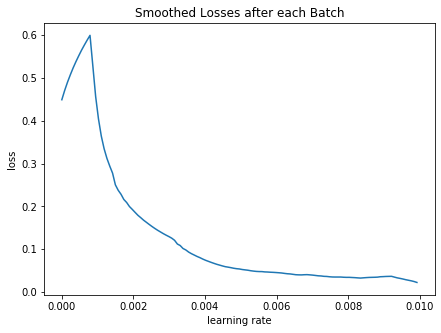

In [7]:
plot_lr_finder(lr_finder.lrs, lr_finder.losses, 20)

In [9]:
get_lr_range(lr_finder.losses, 20, lr_finder.lrs)

learning rate range: [0.0012599299661815166, 0.0048032039776444435]


In [13]:
lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.2, patience=2, min_lr=0.00001
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  min_delta=0.0005, 
                                                  patience=8, 
                                                  restore_best_weights=True)
model_check = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir + '/unet_lg_.hdf5',
        save_best_only=True)

In [14]:
unet_lg.compile(Adam(0.001), loss=[dice_bce_loss], metrics=[dice_coeff])

history = unet_lg.fit_generator(train_gen,
                                steps_per_epoch=int(len(train_ids) / 32),
                                epochs=30,
                                validation_data=val_gen,
                                validation_steps=int(len(val_ids) / 32),
                                callbacks=[lr_plateau,
                                           early_stopping, 
                                           model_check])

Epoch 1/30
127/127 [==============================] - 2197s 17s/step - loss: 0.0327 - dice_coeff: 0.9836 - val_loss: 2.4071 - val_dice_coeff: 0.0020
Epoch 2/30
127/127 [==============================] - 2177s 17s/step - loss: 0.0079 - dice_coeff: 0.9959 - val_loss: 2.8014 - val_dice_coeff: 0.0069
Epoch 3/30
127/127 [==============================] - 2171s 17s/step - loss: 8.5618e-04 - dice_coeff: 0.9995 - val_loss: 1.2747 - val_dice_coeff: 0.7266
Epoch 4/30
127/127 [==============================] - 2203s 17s/step - loss: 1.6591e-04 - dice_coeff: 0.9999 - val_loss: 0.1970 - val_dice_coeff: 0.9610
Epoch 5/30
127/127 [==============================] - 2167s 17s/step - loss: 9.2161e-05 - dice_coeff: 0.9999 - val_loss: 0.0982 - val_dice_coeff: 0.9791
Epoch 6/30
127/127 [==============================] - 2181s 17s/step - loss: 6.2084e-05 - dice_coeff: 1.0000 - val_loss: 0.0921 - val_dice_coeff: 0.9806
Epoch 7/30
127/127 [==============================] - 2154s 17s/step - loss: 4.5086e-05 - 

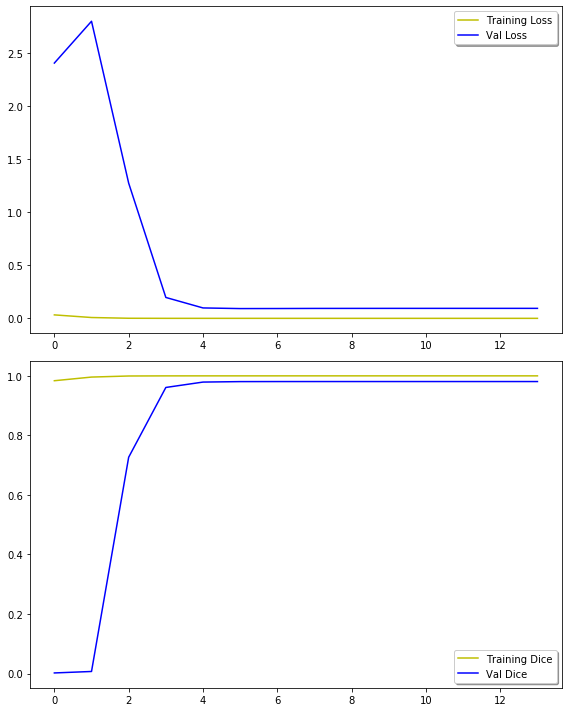

In [15]:
plot_losses(history.history)

In [16]:
test_gen = get_generator(
    train_folder, mask_folder, val_ids, val_masks, 
        batch_size=15, img_size=[128, 128, 3]
)
test_imgs, test_masks = next(test_gen)

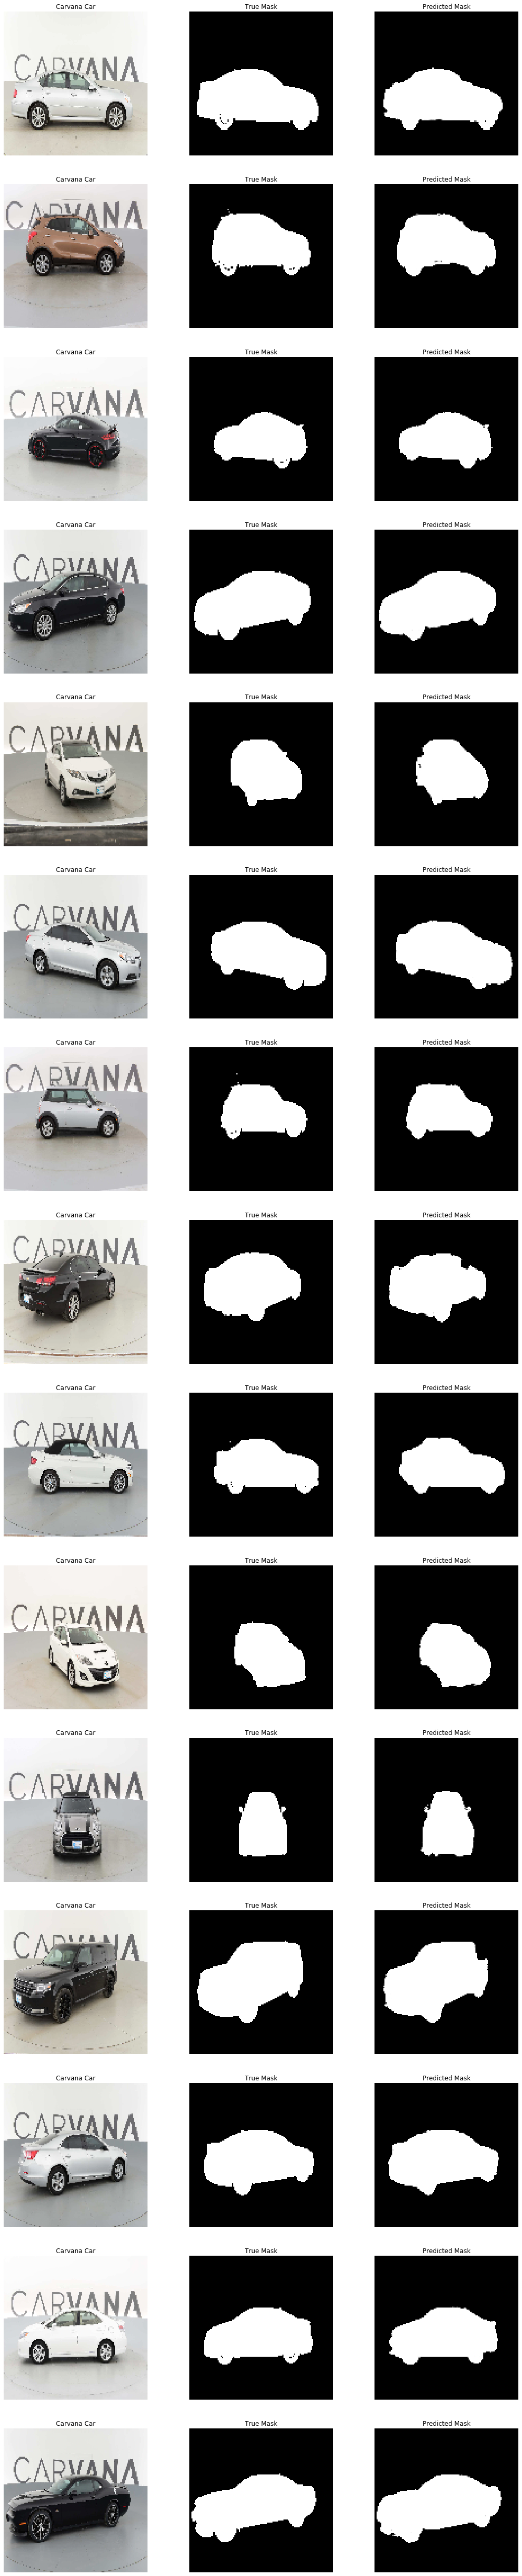

In [17]:
test_preds = unet_lg.predict(test_imgs)

make_inference(test_imgs, test_masks, test_preds, 15)

In [20]:
test_masks = test_masks.astype('float32')
test_preds = test_preds.astype('float32')

dice_loss_sample = dice_bce_loss(test_masks, test_preds)
dice_coeff_sample = dice_coeff(test_masks, test_preds)

print(f'Dice loss on batch: {dice_loss_sample:.6f}')
print(f'Dice coefficient on batch: {dice_coeff_sample:.4f}')

Dice loss on batch: 0.110304
Dice coefficient on batch: 0.9783
